# Simulación Monte Carlo: Distribución de Rayleigh

#### Descripción:

[TODO]


#### Autor:

  * Sergio García Prado - [garciparedes.me](https://garciparedes.me)
  

#### Fecha:

  Mayo de 2018

In [1]:
rm(list = ls())

In [2]:
library(ggplot2)
library(gridExtra)
library(tidyr)
library(magrittr)


Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract



## Contexto

*Unos determinados componentes de hardware informático tienen una vida útil que se comporta según la distribución de Rayleigh, de parámetro $\sigma = 1$ año, según información fiable recibida del fabricante. La función de densidad del modelo de Rayleigh es sobradamente conocida por todos:* 

$$f(x) = \frac{x}{\sigma^2}exp\left(-\frac{x^2}{2\sigma^2}\right), \ x >0$$

*Se tiene un equipo informático en cuya fabricación se incorpora un dispositivo formado **$11$ componentes** de los anteriores, que pueden estar acoplados según diferentes esquemas según se indica má adelante. Se supone que el equipo informático está funcionando ininterrumpidamente desde su puesta en marcha y que, idealmente, solo son posibles los fallos de los componetes que se están estudiando.*

Uno de los primeros pasos antes de comenzar a realizar el ejercicio es el de definir la función de densidad de la distribución de Rayleigh, para poder trabajar con ella, así como estudiar su forma:

In [3]:
rayleigh.density <- function(x, sigma = 1) {
    x / sigma ^ 2 * exp(- x ^ 2 / (2 * sigma ^ 2))
}

Función de distribución:

\begin{align}
F(x) &= \int_0^x f(t) \,dt \\
&= \int_0^x \frac{t}{\sigma^2}exp\left(-\frac{t^2}{2\sigma^2}\right) \,dt \\
&= \left(-exp\left(-\frac{t^2}{2\sigma^2}\right)\right]_0^x \\
&= 1 -exp\left(-\frac{x^2}{2\sigma^2}\right), \ x >0
\end{align}

In [4]:
rayleigh.distribution <- function(x, sigma = 1) {
    1 - exp(- x ^ 2 / (2 * sigma ^ 2))
}

Ahora, necesitamos invertir la función de distribución para llegar a la transformación cuantil, la cual utilizaremos para llevar a cabo la simulación Monte Carlo. A continuación se indican los pasos necesarios para la inversión de $F(x)$:

\begin{align}
y  &= 1 -exp \left( - \frac{x^2}{2 \sigma ^ 2}\right) \\
1 - y  &= exp \left(- \frac{x^2}{2 \sigma ^ 2}\right) \\
ln\left(1 - y \right) &= -\frac{x ^ 2}{2 \sigma ^ 2} \\
-2\sigma^2ln\left(1 - y \right)  &= x^2 \\
\sigma\sqrt{-2ln\left(1 - y \right)}  &= x
\end{align}

Una vez invertida, la transformación cuantil para la distribución de Rayleigh es la siguiente:

\begin{equation}
F^{-1}(x) = \sigma\sqrt{-2ln\left(1 - x \right)}, \ x \in [0, 1]
\end{equation}

In [5]:
rayleigh.quantile <- function(x, sigma = 1) {
    sigma * sqrt(- 2 * log(1 - x))
}

Para comprender mejor el comportamiento de esta distribución, es muy util representar gráficamente las funciones descritas superiormente:

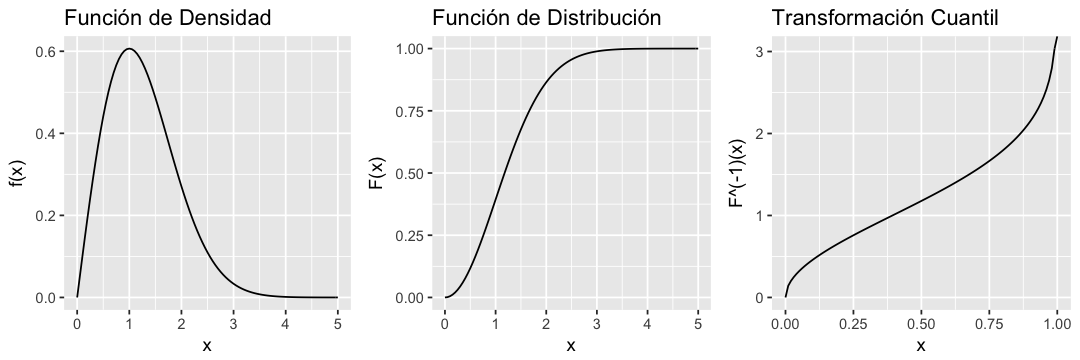

In [6]:
options(repr.plot.height = 3, repr.plot.width = 9)
grid.arrange(
    ggplot(data.frame(x=c(0, 5)), aes(x)) + 
        stat_function(fun = rayleigh.density) +
        ylab("f(x)") + 
        ggtitle("Función de Densidad"), 
    ggplot(data.frame(x=c(0, 5)), aes(x)) + 
        stat_function(fun = rayleigh.distribution) +
        ylab("F(x)") + 
        ggtitle("Función de Distribución"), 
    ggplot(data.frame(x=c(0, 1)), aes(x)) + 
        stat_function(fun = rayleigh.quantile) +
        ylab("F^(-1)(x)") + 
        ggtitle("Transformación Cuantil"),
    ncol = 3)

### Apartado A

El enunciado del apartado es:

*Realizar un experimento de simulación Montecarlo para tener una aproximación razonable del comportamiento de las variables que se describen a continuación.*

*En el trabajo hay que describir y justificar razonadamente todos los pasos que se dan en el experimento de simulación.
Se recomienda recordar lo estudiado acerca de la transformación cuantil y la simulación de variables aleatorias en el Capítulo 4 del material de *del Barrio & Gordaliza*.*

*Se recomienda simular entre $5000$ y $10000$ muestras y presentar sendos histogramas como aproximaciones empíricas al modelo probabilístico (función de densidad) de cada una de las variables indicadas en los cinco subapartados.*

In [7]:
s <- 7500
c <- 11

uniform.sample <- 
    matrix(runif(s * c, min = 0, max = 1), ncol = c, nrow = s) %>%
    as.data.frame() %>%
    set_colnames(sprintf("C%02d", 1:c))

rayleigh.sample <- 
    rayleigh.quantile(uniform.sample)

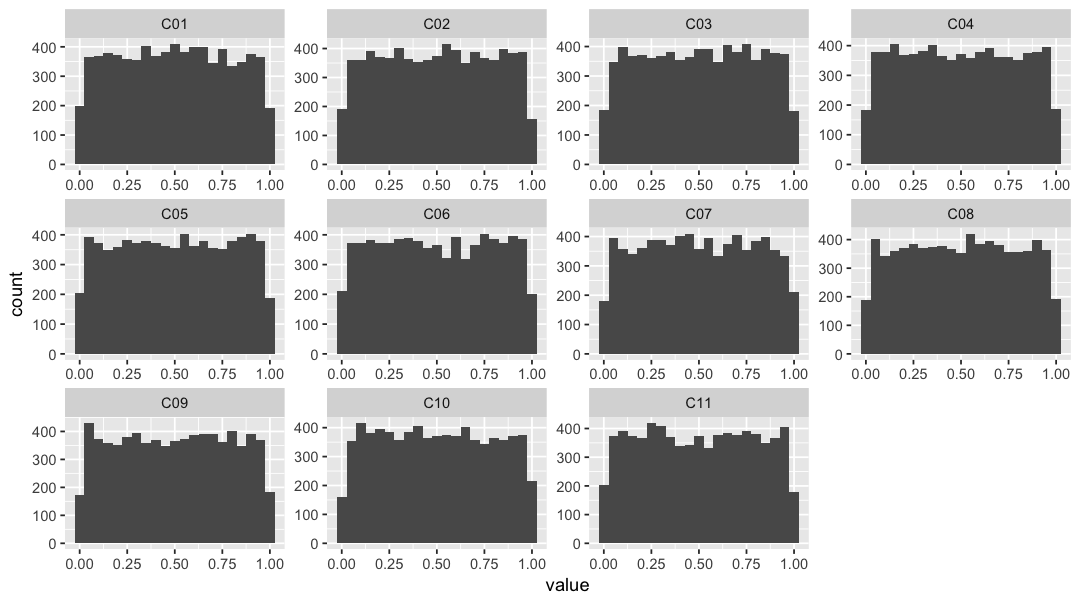

In [8]:
options(repr.plot.height = 5, repr.plot.width = 9)
uniform.sample %>%
    gather() %>% 
    ggplot(aes(value)) +
        facet_wrap(~ key, scales = "free") + 
        geom_histogram(binwidth = 0.05) 

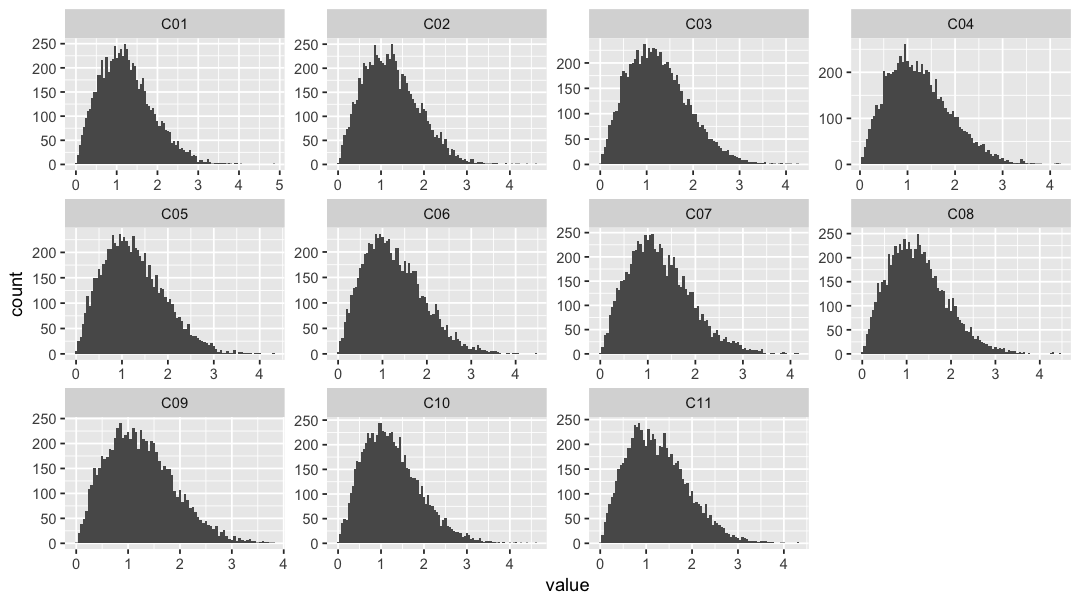

In [9]:
options(repr.plot.height = 5, repr.plot.width = 9)
rayleigh.sample %>%
    gather() %>% 
    ggplot(aes(value)) +
        facet_wrap(~ key, scales = "free") + 
        geom_histogram(binwidth = 0.05) 

#### Apartado A.1

El enunciado del apartado es:

*La duración del dispositivo si los componentes están acoplados **en serie** (el dispositivo funciona mientras todos los componentes estén en funcionamiento).*

In [10]:
rayleigh.sample$series <- 
    rayleigh.sample %>% 
    dplyr::select(dplyr::starts_with("C")) %>% 
    apply(1, min)

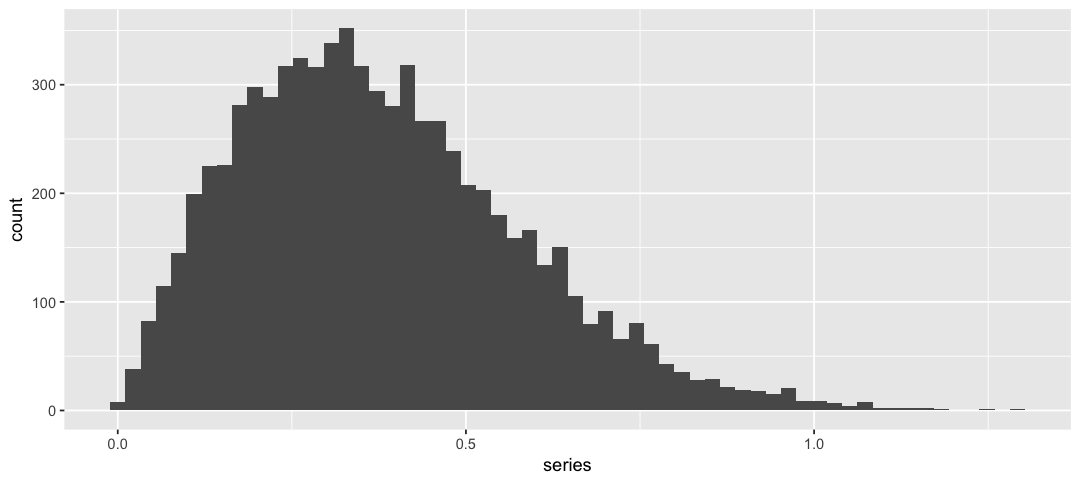

In [11]:
options(repr.plot.height = 4, repr.plot.width = 9)
rayleigh.sample %>%
    ggplot(aes(series)) +
    geom_histogram(bins = 60)

#### Apartado A.2

El enunciado del apartado es:

*La duración del dispositivo si los componentes están acoplados **en paralelo** (el dispositivo funciona mientras alguno de los componentes estén funcionamiento)*

In [12]:
rayleigh.sample$parallel <- 
    rayleigh.sample %>% 
    dplyr::select(dplyr::starts_with("C")) %>% 
    apply(1, max)

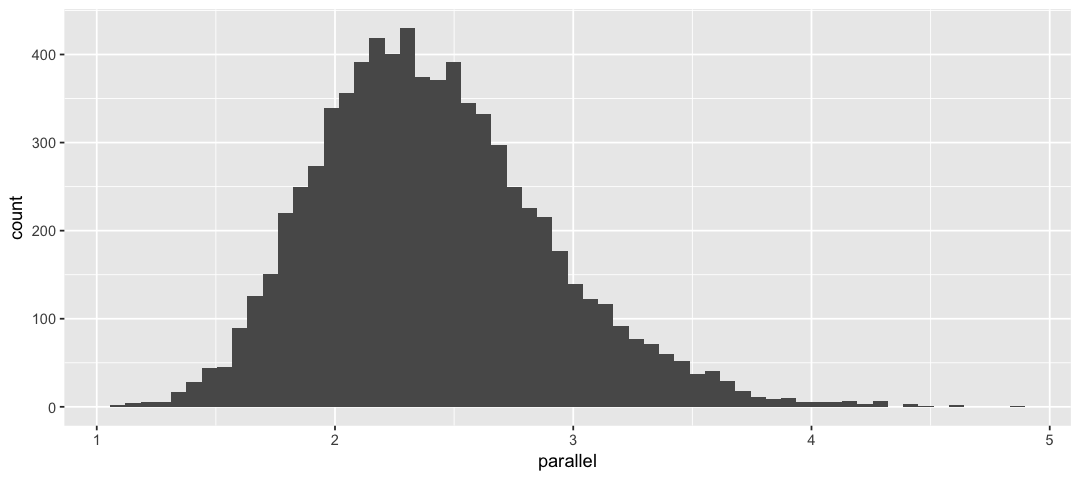

In [13]:
options(repr.plot.height = 4, repr.plot.width = 9)
rayleigh.sample %>%
    ggplot(aes(parallel)) +
    geom_histogram(bins = 60)

#### Apartado A.3

El enunciado del apartado es:

*La duración del dispositivo si los componentes están acoplados en "stand by", según se explica para esta modalidad de acoplamiento en el material de *del Barrio & Gordaliza* en el capítulo "Modelos de fiabilidad. La ley de Weibull."*

In [14]:
rayleigh.sample$stand.by <- 
    rayleigh.sample %>% 
    dplyr::select(dplyr::starts_with("C")) %>% 
    apply(1, sum)

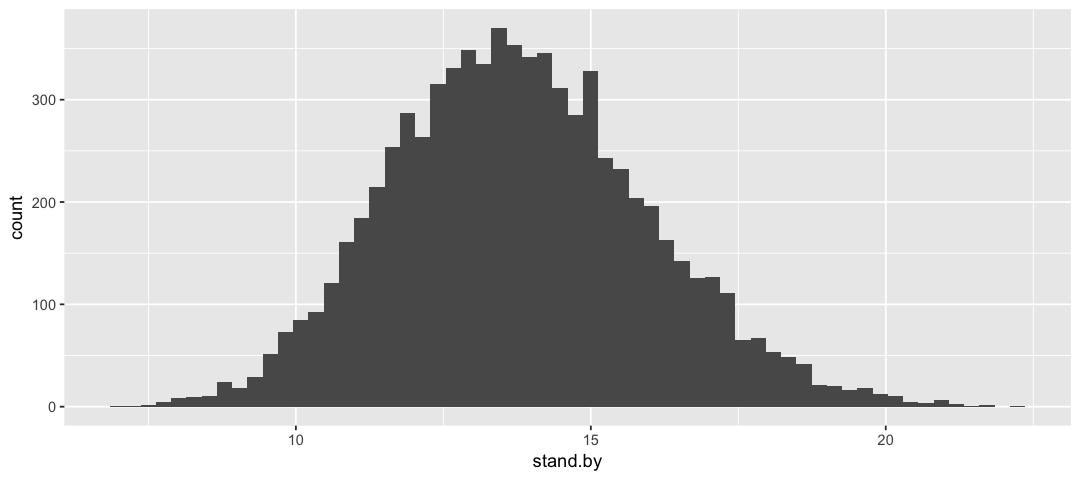

In [15]:
options(repr.plot.height = 4, repr.plot.width = 9)
rayleigh.sample %>%
    ggplot(aes(stand.by)) +
    geom_histogram(bins = 60)

#### Apartado A.4

El enunciado del apartado es:

*La duración del dispositivo si los componentes están acoplados de tal forma que **el dispositivo funciona mientras al menos seis de los componentes estén en funcionamiento**.*

In [16]:
rayleigh.sample$least.6 <- 
    rayleigh.sample %>% 
    dplyr::select(dplyr::starts_with("C")) %>% 
    apply(1, sort) %>%
    {t(.)[, 6]}

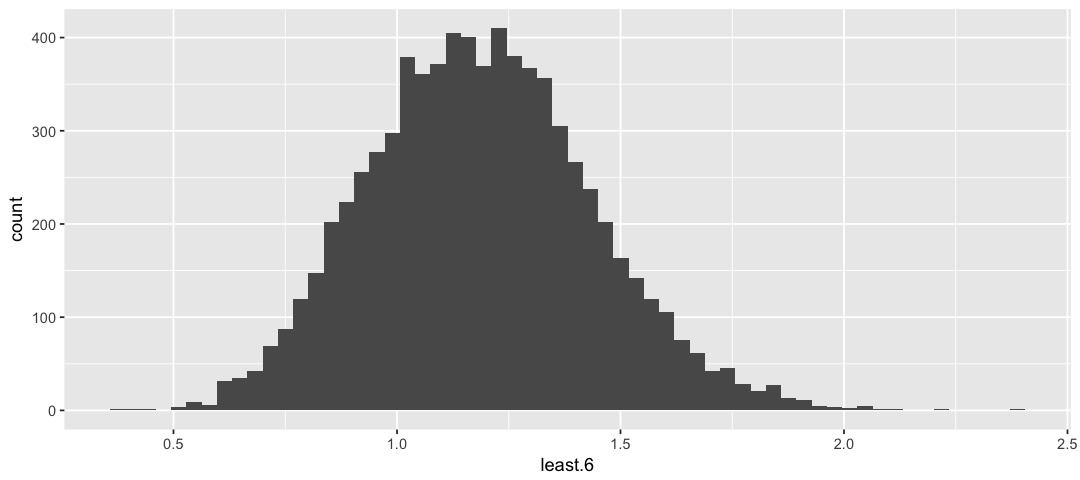

In [17]:
options(repr.plot.height = 4, repr.plot.width = 9)
rayleigh.sample %>%
    ggplot(aes(least.6)) +
    geom_histogram(bins = 60)

#### Apartado A.5

El enunciado del apartado es:

*La duración promedio de los once componentes si se supone que todos comienzan su funcionamiento a la vez y el dispositivo se mantiene activo hasta que todos han fallado.*

In [18]:
rayleigh.sample$mean <- 
    rayleigh.sample %>% 
    dplyr::select(dplyr::starts_with("C")) %>% 
    apply(1, mean)

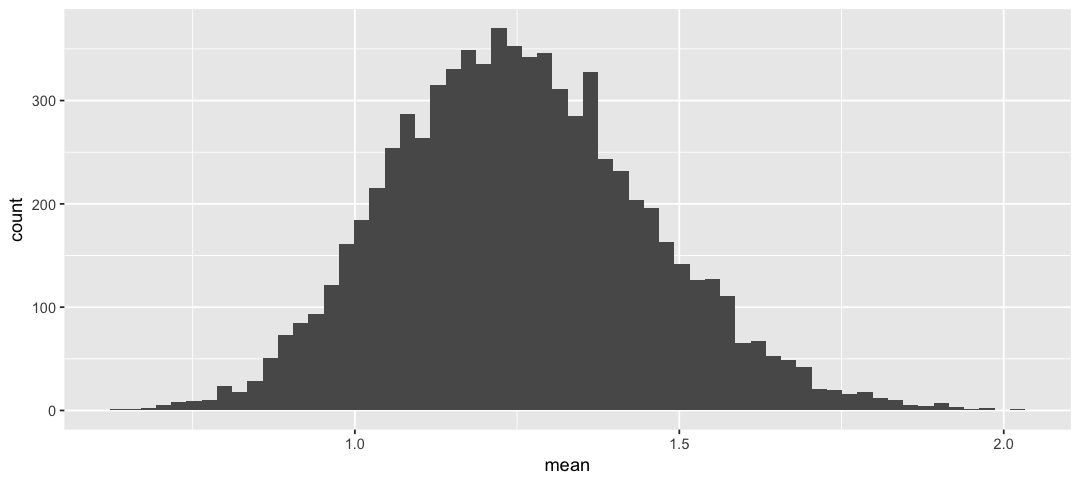

In [19]:
options(repr.plot.height = 4, repr.plot.width = 9)
rayleigh.sample %>%
    ggplot(aes(mean)) +
    geom_histogram(bins = 60)

### Apartado B

El enunciado del apartado es:

*En todos los casos que se decriben en el apartado anterior, a partir de las simulaciones obtener una aproximación (estimación puntual) de los siguientes parámetros de la variable estudiaba: la media, la desviación típica, el percentil $2$ y la probabilidad de que la variable supere el valor $1.5$ anós.*

### Apartado C

El enunciado del apartado es:

*Para los casos descritos en los apartados [A.1](#Apartado-A.1) y [A.2](#Apartado-A.2), obtener también una expresión analítica de la función de densidad de las variables siguiendo las indicaciones dadas en el material de *del Barrio & Gordaliza* en el capítulo "Modelos de fiabilidad. La ley de Weibull". Hacer una representación de dichas funciones superpuestas sobre los histogramas obtenidos por las simulaciones de Montecarlo.*